In [463]:
# import packages
import argparse, os, sys
from os import listdir
from os.path import isfile, join
import pickle
import math
import collections
import time

import numpy as np
import pandas as pd
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import silhouette_score
from functools import partial

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

import anndata
from scipy.stats import spearmanr

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import gseapy as gp
from gseapy.plot import barplot, dotplot

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.sparse import csr_matrix
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
import matplotlib.backends.backend_pdf
%matplotlib inline

In [464]:
# import x10 files and add metadata for annotation

# mCherry Low
low_veh_mCherry=sc.read_10x_mtx("/Users/moo4005/Desktop/Nature_paper_revision/scRNAseq/Low_Veh_mCherry/filtered_feature_bc_matrix",
                                var_names='gene_symbols',cache=True, gex_only=True)
low_veh_mCherry.obs['sample'] = "low_veh_mCherry"

low_cis_mCherry=sc.read_10x_mtx("/Users/moo4005/Desktop/Nature_paper_revision/scRNAseq/Low_Cis_mCherry/filtered_feature_bc_matrix",
                                var_names='gene_symbols',cache=True, gex_only=True)
low_cis_mCherry.obs['sample'] = "low_cis_mCherry"


# GFP Low
low_veh_GFP=sc.read_10x_mtx("/Users/moo4005/Desktop/Nature_paper_revision/scRNAseq/Low_Veh_GFP/filtered_feature_bc_matrix",
                                var_names='gene_symbols',cache=True, gex_only=True)
low_veh_GFP.obs['sample'] = "low_veh_GFP"

low_cis_GFP=sc.read_10x_mtx("/Users/moo4005/Desktop/Nature_paper_revision/scRNAseq/Low_Cis_GFP/filtered_feature_bc_matrix",
                                var_names='gene_symbols',cache=True, gex_only=True)
low_cis_GFP.obs['sample'] = "low_cis_GFP"



adata = anndata.concat([low_cis_GFP, low_cis_mCherry ])


# and delete individual datasets to save space
del(low_veh_mCherry, low_cis_mCherry, 
                       low_veh_GFP, low_cis_GFP, 
                      )

print(adata.obs['sample'].value_counts())

low_cis_GFP        8704
low_cis_mCherry    4774
Name: sample, dtype: int64


In [465]:
# Preprocessing
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

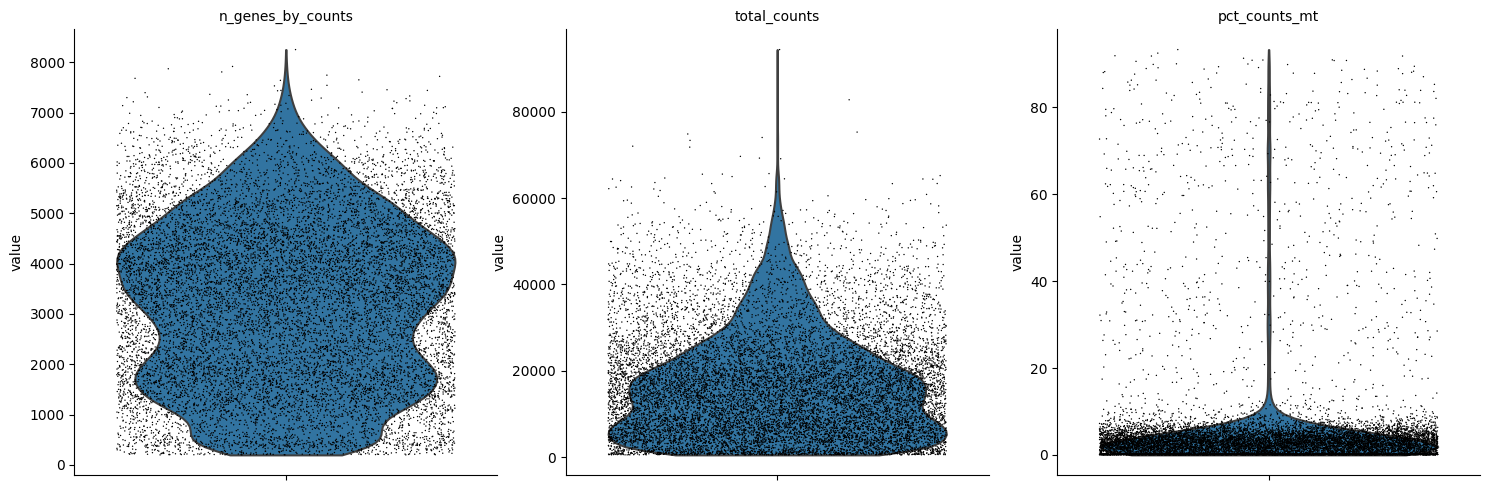

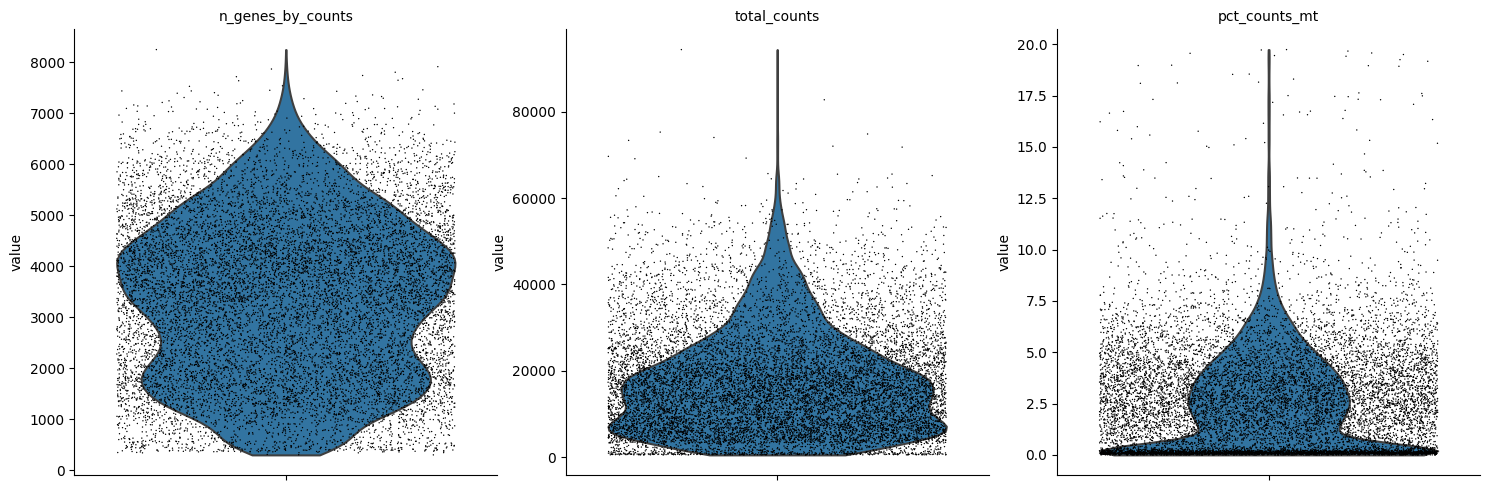

In [466]:
# filtering mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

if not (adata.obs.pct_counts_mt == 0).all():
    adata = adata[adata.obs.pct_counts_mt < 20, :]


sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [467]:
sc.pp.normalize_total(adata, target_sum=1e4)
adata.raw = adata.copy()

In [468]:
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, batch_key='sample')

if 'features' in adata.raw.var.columns:
    adata.raw.var.index = adata.raw.var['features']
adata = adata[:, adata.var.highly_variable]

In [469]:
#scale
sc.pp.scale(adata)

In [470]:
# PCA and BATCH Correction
sc.tl.pca(adata, svd_solver='arpack')
sc.external.pp.harmony_integrate(adata, key = 'sample')

2024-02-20 10:41:47,616 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-02-20 10:41:51,029 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-02-20 10:41:51,054 - harmonypy - INFO - Iteration 1 of 10
2024-02-20 10:41:52,765 - harmonypy - INFO - Iteration 2 of 10
2024-02-20 10:41:54,070 - harmonypy - INFO - Iteration 3 of 10
2024-02-20 10:41:55,438 - harmonypy - INFO - Iteration 4 of 10
2024-02-20 10:41:56,706 - harmonypy - INFO - Iteration 5 of 10
2024-02-20 10:41:57,953 - harmonypy - INFO - Iteration 6 of 10
2024-02-20 10:41:59,322 - harmonypy - INFO - Iteration 7 of 10
2024-02-20 10:42:00,124 - harmonypy - INFO - Iteration 8 of 10
2024-02-20 10:42:00,690 - harmonypy - INFO - Iteration 9 of 10
2024-02-20 10:42:01,354 - harmonypy - INFO - Iteration 10 of 10
2024-02-20 10:42:01,927 - harmonypy - INFO - Stopped before convergence


In [471]:
# creating E2F score
#https://www.gsea-msigdb.org/gsea/msigdb/cards/HALLMARK_E2F_TARGETS.html
e2f_hallmark = ['AK2','ANP32E','ASF1A','ASF1B','ATAD2','AURKA','AURKB','BARD1','BIRC5','BRCA1','BRCA2','BRMS1L','BUB1B','CBX5','CCNB2','CCNE1','CCP110','CDC20','CDC25A','CDC25B','CDCA3','CDCA8','CDK1','CDK4','CDKN1A','CDKN1B','CDKN2A','CDKN2C','CDKN3','CENPE','CENPM','CHEK1','CHEK2','CIT','CKS1B','CKS2','CNOT9','CSE1L','CTCF','CTPS1','DCK','DCLRE1B','DCTPP1','DDX39A','DEK','DEPDC1','DIAPH3','DLGAP5','DNMT1','DONSON','DSCC1','DUT','E2F8','EED','EIF2S1','ESPL1','EXOSC8','EZH2','GINS1','GINS3','GINS4','GSPT1','H2AX','H2AZ1','HELLS','HMGA1','HMGB2','HMGB3','HMMR','HNRNPD','HUS1','ILF3','ING3','IPO7','JPT1','KIF18B','KIF22','KIF2C','KIF4A','KPNA2','LBR','LIG1','LMNB1','LUC7L3','LYAR','MAD2L1','MCM2','MCM3','MCM4','MCM5','MCM6','MCM7','MELK','MKI67','MLH1','MMS22L','MRE11','MSH2','MTHFD2','MXD3','MYBL2','MYC','NAA38','NAP1L1','NASP','NBN','NCAPD2','NME1','NOLC1','NOP56','NUDT21','NUP107','NUP153','NUP205','ORC2','ORC6','PA2G4','PAICS','PAN2','PCNA','PDS5B','PHF5A','PLK1','PLK4','PMS2','PNN','POLA2','POLD1','POLD2','POLD3','POLE','POLE4','POP7','PPM1D','PPP1R8','PRDX4','PRIM2','PRKDC','PRPS1','PSIP1','PSMC3IP','PTTG1','RACGAP1','RAD1','RAD21','RAD50','RAD51AP1','RAD51C','RAN','RANBP1','RBBP7','RFC1','RFC2','RFC3','RNASEH2A','RPA1','RPA2','RPA3','RRM2','SHMT1','SLBP','SMC1A','SMC3','SMC4','SMC6','SNRPB','SPAG5','SPC24','SPC25','SRSF1','SRSF2','SSRP1','STAG1','STMN1','SUV39H1','SYNCRIP','TACC3','TBRG4','TCF19','TFRC','TIMELESS','TIPIN','TK1','TMPO','TOP2A','TP53','TRA2B','TRIP13','TUBB','TUBG1','UBE2S','UBE2T','UBR7','UNG','USP1','WDR90','WEE1','XPO1','XRCC6','ZW10']

sc.tl.score_genes(adata, e2f_hallmark, score_name = 'e2f_hallmark_score' )

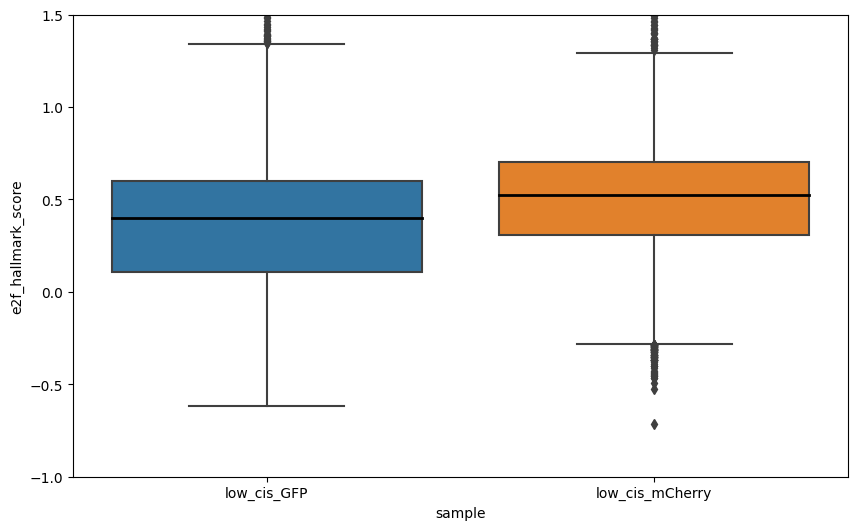

In [472]:
# draw Box plot to compare E2F score between sampels

df = pd.DataFrame({
    'e2f_hallmark_score': adata.obs['e2f_hallmark_score'],
    'sample': adata.obs['sample']
})

# Apply the custom order to the 'sample' column
df['sample'] = pd.Categorical(df['sample'],  ordered=True) 

# Plot using seaborn
plt.figure(figsize=(10, 6))  # Adjust the figure size
#ax = sns.violinplot(x='sample', y='e2f_hallmark_score', data=df, palette='Paired', medianprops={"color": "black", "linewidth": 2}, inner=None)
'''
ax = sns.boxplot(x='sample', y='e2f_hallmark_score', data=df,  medianprops={"color": "black", "linewidth": 2},
                palette={'low_veh_GFP':'#aed9b6',
                   'low_veh_mCherry':'#cc8787',})
'''
ax = sns.boxplot(x='sample', y='e2f_hallmark_score', data=df,  medianprops={"color": "black", "linewidth": 2},
              )

plt.ylim(-1, 1.5)
'''
# Define pairs for comparison
pairs = [('low_cis_GFP',  'low_cis_mCherry'),
        ]

# Initialize the annotator with the Mann-Whitney test
annotator = Annotator(ax, pairs, data=df, x='sample', y='e2f_hallmark_score')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
annotator.apply_and_annotate()
# Set the y-axis limits
'''

# Save the figure as a high-resolution SVG
#plt.savefig('boxPLot_cis.svg', format='svg')

plt.show()

In [473]:
#df.to_csv("cis_boxplot_source_table.csv")

In [424]:
# prepare UMAP and Leiden
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=40)
sc.tl.umap(adata, min_dist=0.01) 

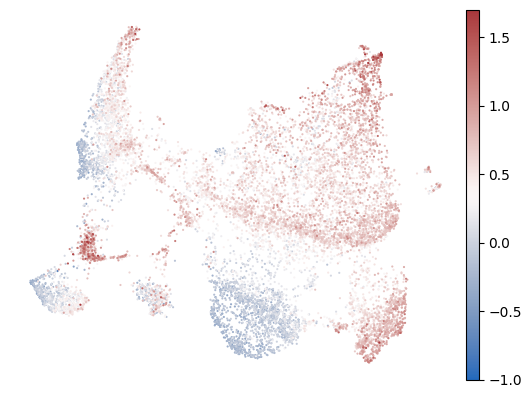

In [425]:
#sc.tl.leiden(adata, resolution=0.15)
# plot UMAPs
sc.pl.umap(adata, color=['e2f_hallmark_score'], vmin=-1, vmax=1.7, frameon = False, cmap='vlag',
          legend_fontsize=10, legend_fontoutline=2,
         title="", 
          )# save="new_veh.pdf"

In [19]:
# DGE
'''
# Finding differentially expressed genes
method = "t-test"
sc.tl.rank_genes_groups(adata, 'sample', method=method, pts=True)


# get deg result
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})
'''

# export DEGs
#degs.to_csv("DEG_veh.csv")

'\n# Finding differentially expressed genes\nmethod = "t-test"\nsc.tl.rank_genes_groups(adata, \'sample\', method=method, pts=True)\n\n\n# get deg result\nresult = adata.uns[\'rank_genes_groups\']\ngroups = result[\'names\'].dtype.names\ndegs = pd.DataFrame(\n    {group + \'_\' + key: result[key][group]\n    for group in groups for key in [\'names\',\'scores\', \'pvals\',\'pvals_adj\',\'logfoldchanges\']})\n'

In [20]:
# GSEA

# subset up or down regulated genes
#degs_sig = degs[degs.low_veh_mCherry_pvals_adj < 0.05]
#degs_up = degs_sig[degs_sig.low_veh_mCherry_logfoldchanges > 0]
#degs_dw = degs_sig[degs_sig.low_veh_mCherry_logfoldchanges < 0]

In [21]:
#degs_up.to_csv("veh_deg_UPregulated.csv")
#degs_dw.to_csv("veh_deg_DOWNregulated.csv")

In [22]:
# upRegulated
'''
enr_up = gp.enrichr(degs_up.low_veh_mCherry_names,
                    gene_sets='GO_Biological_Process_2021',
                    outdir=None)
enr_up.res2d.Term = enr_up.res2d.Term.str.split(" \(GO").str[0]
'''
#enr_up.res2d.to_csv("veh_up_GSEA.csv")

'\nenr_up = gp.enrichr(degs_up.low_veh_mCherry_names,\n                    gene_sets=\'GO_Biological_Process_2021\',\n                    outdir=None)\nenr_up.res2d.Term = enr_up.res2d.Term.str.split(" \\(GO").str[0]\n'

In [23]:
#DownRegulated
'''
enr_dw = gp.enrichr(degs_dw.low_veh_mCherry_names,
                    gene_sets='MSigDB_Hallmark_2020',
                    outdir=None)
enr_dw.res2d.Term = enr_dw.res2d.Term.str.split(" \(GO").str[0]
'''
#enr_dw.res2d.to_csv("veh_down_GSEA.csv")

'\nenr_dw = gp.enrichr(degs_dw.low_veh_mCherry_names,\n                    gene_sets=\'MSigDB_Hallmark_2020\',\n                    outdir=None)\nenr_dw.res2d.Term = enr_dw.res2d.Term.str.split(" \\(GO").str[0]\n'

In [24]:
# plot the upRegulated pathways
#ax = barplot(enr_up.res2d, title='Up-regulated pathways', color='#ef3b2c')

# To save the plot
#plt.savefig('upregulated_low_veh_mCherry.svg')

# To display the plot in Jupyter Notebook
#plt.show()

In [25]:
# plot the downRegulated pathways
#ax = barplot(enr_dw.res2d,title='Down-regulated pathways',color = '#2c7fb8')

# To save the plot
#plt.savefig('downregulated_low_veh_mCherry.svg')

# To display the plot in Jupyter Notebook
#plt.show()

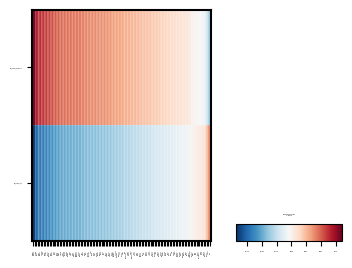

In [26]:
# plot MatrixPlot
e2f_gene_list_filtered = [gene for gene in e2f_hallmark if gene in adata.var_names]
# scale and store results in layer
adata.layers['scaled'] = sc.pp.scale(adata, copy=True).X

adata_mCherry = adata[adata.obs['sample'] == 'low_veh_mCherry', :]

# Calculate the mean expression (or z-score) for each gene in the 'mCherry' sample
mean_expressions_mCherry = adata_mCherry[:, e2f_gene_list_filtered].layers['scaled'].mean(axis=0)

# Convert to a DataFrame 
df_mean_expressions = pd.DataFrame(mean_expressions_mCherry, index=e2f_gene_list_filtered, columns=['mean_expression'])

# Sort the DataFrame by mean expression in descending order
df_sorted = df_mean_expressions.sort_values(by='mean_expression', ascending=False)

# Extract the sorted gene list
sorted_genes = df_sorted.index.tolist()

# Set global font size using matplotlib
plt.rcParams.update({'font.size': 0.5})  

    
mp = sc.pl.MatrixPlot(
    adata=adata,
    var_names=sorted_genes,
    groupby='sample',
    figsize=(4, 3),
    categories_order=['low_veh_mCherry', 'low_veh_GFP'],
    layer='scaled',
    cmap='RdBu_r'
    # Note: `save` argument is not used here; we will save the plot after customization
)

# Now, customize the plot's style to remove borders using the style() method
# Set edge_color to None and edge_lw to 0 to remove the gray borders
mp = mp.style(cmap='RdBu_r', edge_color=None, edge_lw=0)

# Show the plot
mp.show()

# Save the plot after customization
#mp.savefig("_cis.matrixplot.svg")


In [119]:
plt.rcParams.update({'font.size': 10}) 